In [1]:
# import modual
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import os

In [2]:
# import wholesale customers data
df = pd.read_csv('Wholesale customers data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
#Check if there is any missing data
pd.isnull(df).sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [4]:
# replace dummy categorical value to text value
df['Channel'] = df['Channel'].map({1:'Horeca', 2:'Retail'})
df['Region'] = df['Region'].map({1:'Lisbon',2:'Oporo',3:'Other'})

In [5]:
# check data again
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,Retail,Other,12669,9656,7561,214,2674,1338
1,Retail,Other,7057,9810,9568,1762,3293,1776
2,Retail,Other,6353,8808,7684,2405,3516,7844
3,Horeca,Other,13265,1196,4221,6404,507,1788
4,Retail,Other,22615,5410,7198,3915,1777,5185


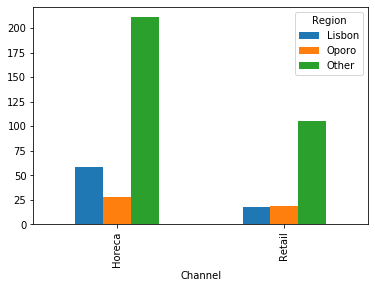

In [6]:
# know the market share of two channels in differnt region
pd.crosstab(df['Channel'],df['Region']).plot(kind='bar')
plt.show()

In [7]:
# only get the columns with numerical value
df_numerical = df[['Fresh',
 'Milk',
 'Grocery',
 'Frozen',
 'Detergents_Paper',
 'Delicassen']]

In [8]:
# replace outliers with the inner fences

for i in list(df_numerical.columns):
    IQR = np.percentile(df_numerical[i],75) - np.percentile(df_numerical[i],25)
    
    outlier_max = np.percentile(df_numerical[i],75) + 1.5*IQR
    Outlier_min = np.percentile(df_numerical[i],25) - 1.5*IQR
    
    df_numerical[i] = np.where(df_numerical[i] > outlier_max,outlier_max,df_numerical[i])
    df_numerical[i] = np.where(df_numerical[i] < Outlier_min,Outlier_min,df_numerical[i])

In [9]:
# create dummy variable for categorical values, better be used as an indicater to create following clusters 
df = pd.get_dummies(df,columns=['Channel','Region'],drop_first=True)
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporo,Region_Other
0,12669,9656,7561,214,2674,1338,1,0,1
1,7057,9810,9568,1762,3293,1776,1,0,1
2,6353,8808,7684,2405,3516,7844,1,0,1
3,13265,1196,4221,6404,507,1788,0,0,1
4,22615,5410,7198,3915,1777,5185,1,0,1


In [10]:
# features scaling
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree

scaler = MinMaxScaler()
df_fit = scaler.fit_transform(df)
df_fit = pd.DataFrame(df_fit,columns=df.columns)
df_fit.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporo,Region_Other
0,0.112940,0.130727,0.081464,0.003106,0.065427,0.027847,1.0,0.0,1.0
1,0.062899,0.132824,0.103097,0.028548,0.080590,0.036984,1.0,0.0,1.0
2,0.056622,0.119181,0.082790,0.039116,0.086052,0.163559,1.0,0.0,1.0
3,0.118254,0.015536,0.045464,0.104842,0.012346,0.037234,0.0,0.0,1.0
4,0.201626,0.072914,0.077552,0.063934,0.043455,0.108093,1.0,0.0,1.0


In [11]:
# Computes the distance between m points using Euclidean distance as the distance metric between the points. 
#The points are arranged as m n-dimensional row vectors in the matrix X.
distance = pdist(df_fit, 'euclidean')

# because I am performing K-means clustering so choosing nearest-neighbors chain method
cluster = linkage(distance,method='average')
names = np.arange(0,df_fit.shape[0]).tolist()

Text(0.5, 1.0, 'cluster dendrogram')

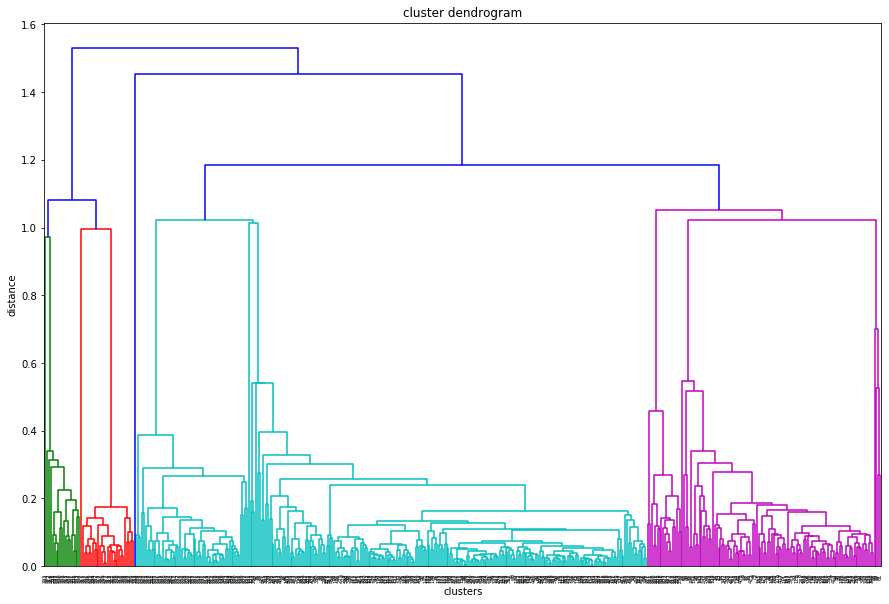

In [12]:
# by creating dendrogram, we can see about how many clusters needed to be created to perfrom accurate analysis
plt.figure(figsize=[15,10])
dendrogram(cluster,labels=names)
plt.xlabel('clusters')
plt.ylabel('distance')
plt.title('cluster dendrogram')

We can see from the above dendrogram, there will be five clusters to create.

In [13]:
# create clusters column lable on each row
df['clusters'] = cut_tree(cluster,5)
cluster_df = df.groupby(['clusters'],as_index=False).mean()
cluster_df

,clusters,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporo,Region_Other
0,0,9153.723577,10952.178862,16322.317073,1669.918699,7093.292683,1832.902439,1.0,0.0,0.853659
1,1,13578.643123,3420.613383,3856.776952,3418.527881,824.654275,1275.267658,0.0,0.0,0.780669
2,2,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000,0.0,0.0,1.000000
3,3,7289.789474,9190.789474,16326.315789,1540.578947,8410.263158,1239.000000,1.0,1.0,0.000000
4,4,11650.535714,2304.250000,4395.500000,5745.035714,482.714286,1105.892857,0.0,1.0,0.000000


"An array indicating group membership at each agglomeration step. I.e., for a full cut tree, in the first column each data point is in its own cluster. At the next step, two nodes are merged. Finally, all singleton and non-singleton clusters are in one group. If n_clusters or height are given, the columns correspond to the columns of n_clusters or height." <br>
Reference sources: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cut_tree.html

In [14]:
from sklearn.cluster import KMeans

# get a clue on when it has 20 clusters what would the visualization looked like
cluster_range = range(1,20)
cluster_inertia=[] 
for cluster in cluster_range:
    
    # creat KMeans object for each cluster
    model = KMeans(cluster)
    
    # fit the data
    model.fit(df_fit)
    
    # take the sum of squared distances of samples to their closest cluster center
    cluster_inertia.append(model.inertia_)

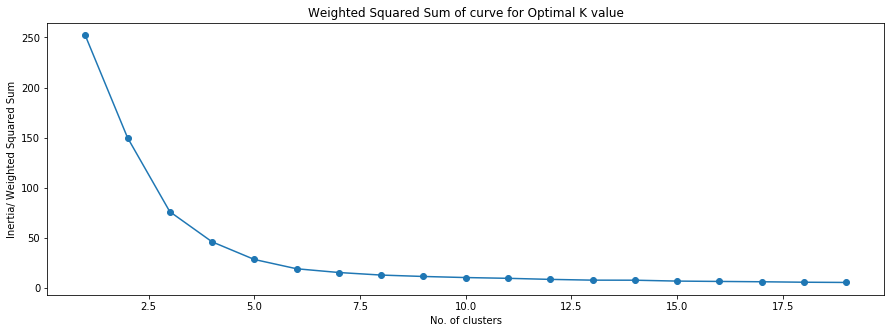

In [15]:
# plot the cluster and its correspondgin weighted sum of squared value
plt.figure(figsize=[15,5])
plt.title('Weighted Squared Sum of curve for Optimal K value')
plt.xlabel('No. of clusters')
plt.ylabel('Inertia/ Weighted Squared Sum')
plt.plot(list(cluster_range),cluster_inertia,marker='o')
plt.show()

In [16]:
# clustering the observations by using K-means with K=4
model = KMeans(n_clusters=5,random_state=0)
model.fit(df_fit)
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporo,Region_Other,clusters
0,12669,9656,7561,214,2674,1338,1,0,1,0
1,7057,9810,9568,1762,3293,1776,1,0,1,0
2,6353,8808,7684,2405,3516,7844,1,0,1,0
3,13265,1196,4221,6404,507,1788,0,0,1,1
4,22615,5410,7198,3915,1777,5185,1,0,1,0


In [17]:
df['clusters']=model.predict(df_fit)
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporo,Region_Other,clusters
0,12669,9656,7561,214,2674,1338,1,0,1,2
1,7057,9810,9568,1762,3293,1776,1,0,1,2
2,6353,8808,7684,2405,3516,7844,1,0,1,2
3,13265,1196,4221,6404,507,1788,0,0,1,1
4,22615,5410,7198,3915,1777,5185,1,0,1,2


In [18]:
# take a look at cluster description
clust_des = df.groupby(['clusters'],as_index=False).mean()
clust_des

,clusters,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_Retail,Region_Oporo,Region_Other
0,0,12902.254237,3870.203390,4026.135593,3127.322034,950.525424,1197.152542,0.0,0.000000,0.0
1,1,13878.052133,3486.981043,3886.734597,3656.900474,786.682464,1518.284360,0.0,0.000000,1.0
2,2,9831.504762,10981.009524,15953.809524,1513.200000,6899.238095,1826.209524,1.0,0.000000,1.0
3,3,6273.135135,9965.864865,17370.135135,2048.243243,8320.270270,1546.918919,1.0,0.513514,0.0
4,4,11650.535714,2304.250000,4395.500000,5745.035714,482.714286,1105.892857,0.0,1.000000,0.0


In [19]:
# PCA analysis with the first 2 principle components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(df_fit)
pca_df = pd.DataFrame(pca_fit)
pca_df.head()


,0,1
0,-0.400866,0.607804
1,-0.400697,0.614901
2,-0.400943,0.612413
3,-0.242987,-0.376346
4,-0.399861,0.592634


In [20]:
pca_cluster = pd.concat([pca_df,df['clusters']],axis=1)
pca_cluster.columns = ['pca1','pca2','clusters']
print(pca_cluster.shape)
pca_cluster.head()

(440, 3)


,pca1,pca2,clusters
0,-0.400866,0.607804,2
1,-0.400697,0.614901,2
2,-0.400943,0.612413,2
3,-0.242987,-0.376346,1
4,-0.399861,0.592634,2


In [21]:
pca_cluster.clusters.value_counts()

1    211
2    105
0     59
3     37
4     28
Name: clusters, dtype: int64

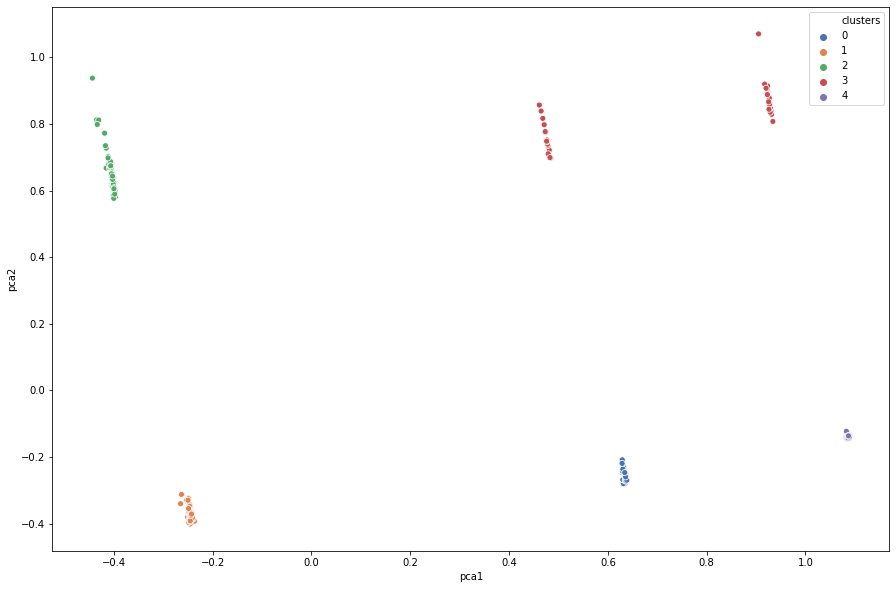

In [22]:
plt.figure(figsize=[15,10])
sns.scatterplot(x='pca1', y='pca2', hue= 'clusters', data=pca_cluster, palette='deep')
plt.show()

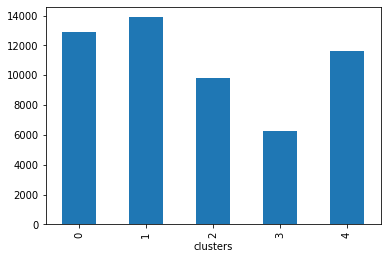

In [23]:
df.groupby('clusters').Fresh.mean().plot(kind='bar')

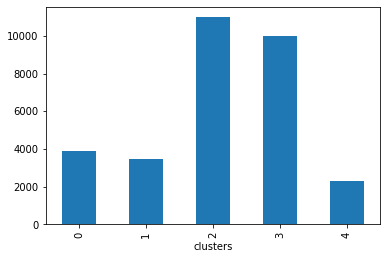

In [24]:
df.groupby('clusters').Milk.mean().plot(kind='bar')


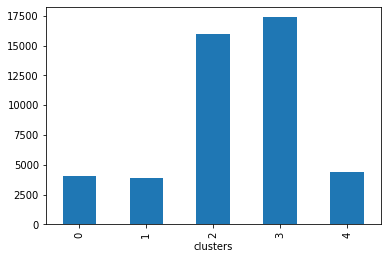

In [25]:
df.groupby('clusters').Grocery.mean().plot(kind='bar')


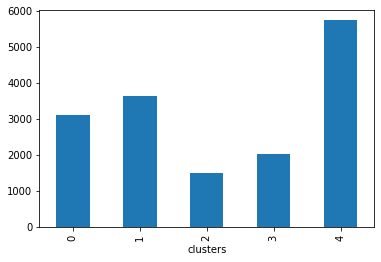

In [26]:
df.groupby('clusters').Frozen.mean().plot(kind='bar')


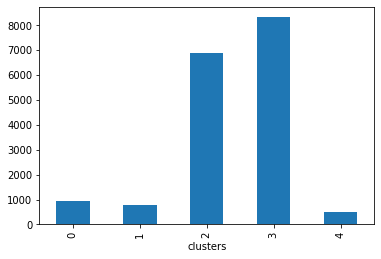

In [27]:
df.groupby('clusters').Detergents_Paper.mean().plot(kind='bar')
